<a href="https://colab.research.google.com/github/sanMil2003/APRENDIZAJE_AUTOMATICO_23_24/blob/main/TEMA%201/3_1_Clasificacion_binaria_criticas_peliculas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificar Críticas de Películas: Ejemplo de Clasificación Binaria

- **Clasificación Binaria**: Problema de Machine Learning más común
- **IMDB**: Internet Movie Data Base: **50K críticas** muy polarizadas (25K entrenamiento y 25K test) (50% Positivas = 1, 50% Negativas =0)
- Nunca probar un modelo con los mismos datos que hemos usado para entrenarlo. Nos interesa el **rendimiento con datos nuevos**
- IMDB está incluida en Keras
- Textos de críticas ya **procesadas** (cada palabra es un dígito de un diccionario de 10K palabras)
- Con ``num_words=10000`` solo mantiene las 10K palabras que más aparecen en los datos de entrenamiento. Se **descartan las palabras raras**. Tamaño manejable

In [1]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000, seed=100000)
#(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) # palabras más frecuentes


In [2]:
#train_data[0] # Crítica codificada (sin palabras poco usadas) (Reflexión sobre esto)

In [3]:
#print(train_labels)
#train_labels[0] # Crítica positiva

In [4]:
# Ningún índice de palabras excederá las 10K palabras porque solo usamos las 10K
# más frecuentes
max([max(sequence) for sequence in train_data])

9999

Por si se tiene la curiosidad de cual es la crítica en cuestión:

In [5]:
# word_index es el diccionario que mapea cada palabra con un ínidice entero
## word_index = imdb.get_word_index()
# print(word_index)
# Lo invertimos, asignando índices de enteros a palabras
## reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# print(reverse_word_index)
# Decodificamos la crítica. Los índices están desviados en 3, porque 0, 1 y 2
# están reservados para "relleno", "inicio de secuencia" y "desconocido"
## decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [6]:
## decoded_review # gano simplicidad, pierdo relevancia y contexto

## Preparación de Datos

No podemos meter en la RNA una lista de enteros, hay que convertirlo a tensores. Dos formas de hacerlo:

1. Rellenar las listas para que tengan la misma longitud y convertirlas en un tensor de enteros con la forma (muestras, indices_palabras), luego usar como primera capa en nuestra red una capa capaz de manejar esos tensores de enteros (la capa `*Embedding*`, que veremos más adelante).
2. Utilizar **codificación one-hot** en las listas para convertirlas en vectores de 0 y 1. Concretamente, esto significaría, por ejemplo, convertir la secuencia [3, 5] en un vector de 10k dimensiones que sería todo ceros excepto los índices 3 y 5, que serían unos. Entonces podríamos usar como primera capa en nuestra red una capa **`Dense`**, capaz de manejar datos vectoriales de punto flotante.

Iremos con la segunda solución. Vectoricemos nuestros datos, lo que haremos manualmente para mayor claridad:

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Crea matriz de ceros con la forma (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # Pasa índices específicos de results[i] a 1s
    return results

# Datos de entrenamiento vectorizados
x_train = vectorize_sequences(train_data)
# Datos de prueba vectorizados
x_test = vectorize_sequences(test_data)

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
# Convertimos el vector de etiquetas en un tensor Numpy de coma flotante
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
y_train

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

Ahora los datos ya están listos para que pasen a la red neuronal

## Construcción de la Red

* Datos de entrada: vectores y etiquetas escalares (1 y 0)
* Un tipo de red que funciona bien con este problema es una simple pila de capas completamente conectadas (densas) con activaciones relu: `Dense(16,activación = 'relu')`
* El 16 es el número de "unidades ocultas" de la capa (una dimensión en el espacio de representación de la capa).
* Cada capa `Dense` con una activación `relu` implementa la siguiente cadena de operaciones de tensor:
```python
salida=relu(dot(W,entrada)+b)
```
* Tener 16 unidades ocultas significa que la **matriz de peso W** tendrá **forma (input_dimension, 16)**, es decir, el producto escalar con W proyectará los datos de entrada en un espacio de representación de 16 dimensiones (y luego agregaríamos el vector de sesgo y la operación ``relu``).
* Intuitivamente, la dimensionalidad de nuestro espacio de representación es **"cuánta libertad permitimos que tenga la red cuando aprende representaciones internas"**. A **mayor número de unidades ocultas** (un espacio de representación de mayor dimensión) **mayor complejidad de representaciones** que permitimos que la red aprenda, pero hace que la **red sea más costosa** computacionalmente y puede conducir al **aprendizaje de patrones no deseados** (patrones que mejorarán el rendimiento en los datos de entrenamiento pero no en el datos de prueba).

Dos **decisiones clave** de arquitectura que se deben tomar sobre dicha pila de capas densas:

* Cuántas capas usar.
* Cuántas "unidades ocultas" elegir para cada capa.

Aprenderemos los principios formales que os guiarán en la toma de estas decisiones, más adelante. Confiar en mi que ahora lo ideal son **dos capas intermedias con 16 unidades ocultas cada una**, y una **tercera capa que generará la predicción escalar** con respecto al sentimiento de la revisión actual.

Las **capas intermedias** usarán ``relu`` como **"función de activación"**, y la **capa final** usará una activación **sigmoidea** para **generar una probabilidad** (una puntuación entre 0 y 1, que indica la probabilidad de que la muestra tenga el objetivo "1", es decir, la probabilidad de que la revisión sea positiva).

Un ``relu`` (**unidad lineal rectificada**) es una **función destinada a poner a cero los valores negativos**, mientras que un **sigmoide** **"aplasta" valores arbitrarios en el intervalo [0, 1]**, generando así algo que puede interpretarse como una probabilidad.

**RELU**

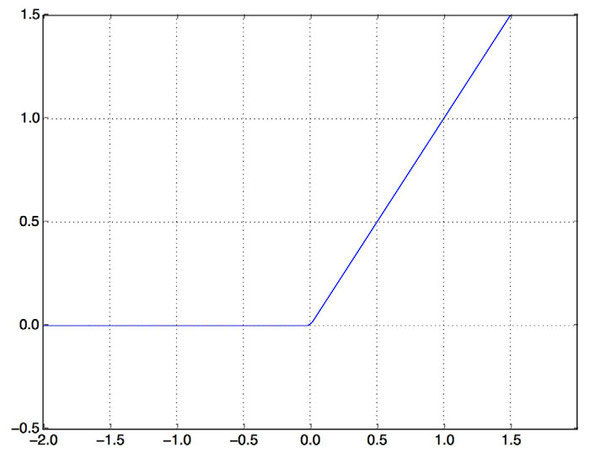

**SIGMOID**

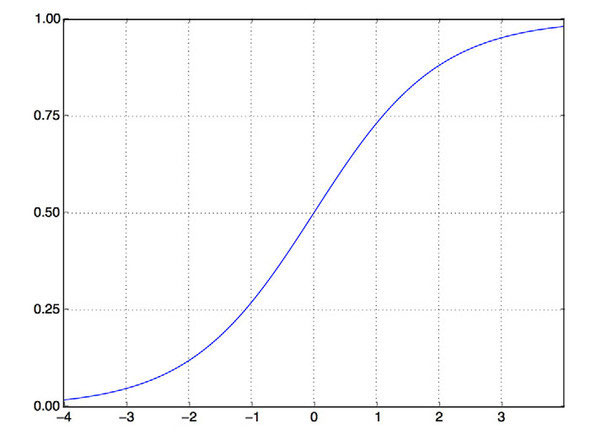

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
# Entrada, un tensor con la crítica vectorizada (10000 valores)
#model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
#model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

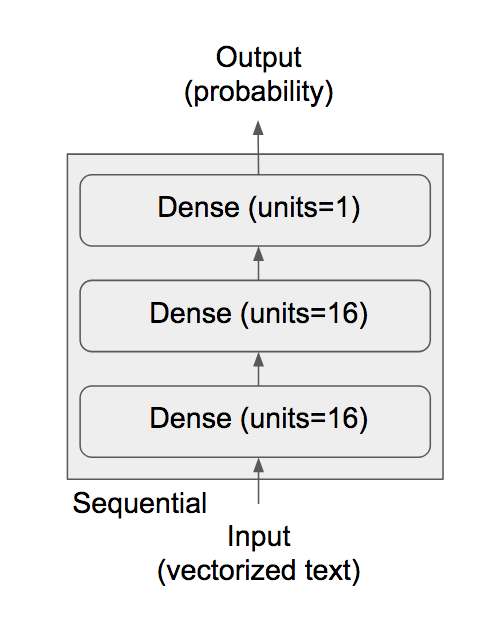

Las funciones de activación son necesarias porque si no, la capa ``Dense``consistiría en solo dos operaciones lineales:
```python
output = dot(W, input) + b
```
con lo que la capa solo podría aprender transformaciones lineales (afines) de los datos de entrada: el "espacio de hipótesis" de la capa sería el conjunto de todas las transformaciones lineales posibles de los datos en un espacio de 16 dimensiones. => Es un espácio muy restringido. Añadir mas capas, no apliaría el espacio de hipótesis. Es por ello por lo que introducimos una función de activación lineal como `relu`. Hay más, como `prelu`, `elu`, etc

* Ejegir **función de pérdida** y un **optimizador**.
* Problema de **clasificación binaria** y la **salida** de nuestra red es una **probabilidad** (terminamos nuestra red con una capa de **una sola unidad** con una activación **sigmoidea**), es mejor usar la pérdida **`binary_crossentropy`**.
* No es la única opción viable: podría usar, por ejemplo, **mean_squared_error**. Pero la **entropía cruzada** suele ser la **mejor opción** cuando se trata de **modelos que generan probabilidades**. La entropía cruzada mide la **"distancia" entre las distribuciones de probabilidad**, o en nuestro caso, entre la distribución de verdad y nuestras predicciones.
* Configuramos nuestro modelo con el optimizador **rmsprop**.
* Supervisaremos la **precisión** durante el entrenamiento.

In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

* Estamos pasando nuestro **optimizador**, **función de pérdida** y **métricas** como **cadenas**, lo cual es posible porque rmsprop, binary_crossentropy y precision están **empaquetados como parte de Keras**.
* A veces, es posible que desee configurar los parámetros de su optimizador o pasar una función de pérdida personalizada o una función métrica. Esto primero se puede hacer pasando una instancia de clase de optimizador como argumento del optimizador

In [12]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validar nuestra Aproximación

Crearemos un **"conjunto de validación"** separando 10K muestras de los datos de entrenamiento originales, para monitorizar la precisión del modelo durante el entrenamiento con datos que nunca había visto

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

* **Entrenamos** nuestro modelo durante **20 épocas** (20 iteraciones sobre todas las muestras en los tensores ``x_train`` e ``y_train``), en **mini lotes de 512 muestras**.
* A la vez, monitorizamos la **pérdida** y la **precisión** de las 10K muestras que separamos. Esto se hace pasando los datos de validación como el argumento ``validation_data``:

In [15]:
#model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['acc'])

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 8s 70ms/step - loss: 0.2005 - acc: 0.6769 - val_loss: 0.1523 - val_acc: 0.7795
Epoch 2/5
30/30 [==============================] - 1s 39ms/step - loss: 0.1156 - acc: 0.8408 - val_loss: 0.1195 - val_acc: 0.8334
Epoch 3/5
30/30 [==============================] - 1s 47ms/step - loss: 0.0890 - acc: 0.8791 - val_loss: 0.0890 - val_acc: 0.8798
Epoch 4/5
30/30 [==============================] - 1s 28ms/step - loss: 0.0767 - acc: 0.8993 - val_loss: 0.0984 - val_acc: 0.8631
Epoch 5/5
30/30 [==============================] - 1s 28ms/step - loss: 0.0622 - acc: 0.9206 - val_loss: 0.0905 - val_acc: 0.8793


* Al final de cada época, hay una pequeña pausa mientras el modelo **calcula su pérdida y precisión** en las 10K muestras de los datos de validación.

* La llamada a ``model.fit()`` devuelve un objeto ``History``. Este objeto tiene un **atributo ``history``**, que es un **diccionario** que contiene datos sobre **todo lo que sucedió durante el entrenamiento**. Echemos un vistazo a esto:

In [16]:
history_dict = history.history
history_dict.keys()
print(history_dict['loss'])
print(history_dict['acc'])
print(history_dict['val_loss'])
print(history_dict['val_acc'])

[0.20050469040870667, 0.11562736332416534, 0.08900672942399979, 0.07666490972042084, 0.062242571264505386]
[0.6769333481788635, 0.8407999873161316, 0.8791333436965942, 0.8992666602134705, 0.9205999970436096]
[0.15231822431087494, 0.11954855918884277, 0.08897829800844193, 0.09843797981739044, 0.0904974564909935]
[0.7795000076293945, 0.8334000110626221, 0.879800021648407, 0.863099992275238, 0.8792999982833862]


* El diccionario contiene 4 entradas: una por métrica que se estaba monitorizando durante el entrenamiento y durante la validación.
* Usaremos **Matplotlib** para graficar la **pérdida** de **entrenamiento** y la de **validación** una al lado de otra, así como la **precisión** de **entrenamiento** y **validación**:
* Las posibles diferencias entre una ejecución y otra es debida a la inicialización aleatoria de los pesos

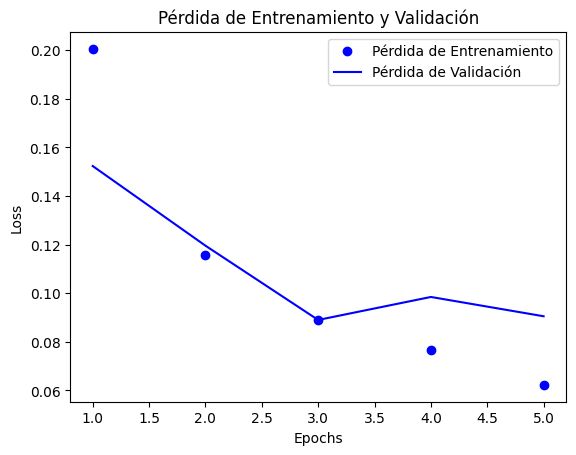

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

* Se ve claramente que **cuanto más se entrena**, **menor es la pérdida durante el entrenamiento**

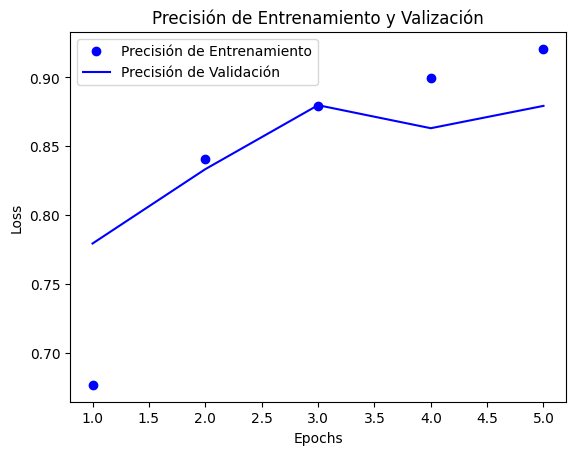

In [18]:
plt.clf()   # Limpia la figura
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Valización')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

* Se ve claramente que **cuanto más se entrena**, **mayor es la precisión del modelo durante el entrenamiento**

* Eso es lo que esperaría al ejecutar la **optimización del descenso de gradientes**: la cantidad que está tratando de minimizar debería disminuir con cada iteración, como así acurre
* No es el caso de la **pérdida y precisión de la validación**: parecen alcanzar su **punto máximo en la cuarta época**.
* **Un modelo con un desempeño mejor en los datos de entrenamiento no es necesariamente mejor en datos que nunca antes había visto**
* Esto es debido al concepto que llevamos advirtiendo estos dias: **"sobreajuste"**:
* Tras cada segunda repetición, estamos **sobreoptimizando los datos de entrenamiento** y terminamos **aprendiendo representaciones que son específicas de los datos de entrenamiento** y **no se generalizan** a datos fuera del conjunto de entrenamiento.
* **EVITAR SOBREAJUSTE**:
  - Dejar de entrenar después de tres épocas.

Lo veremos con más detalle más adelante

Entrenemos una nueva red desde cero durante cuatro épocas, luego la evaluaremos con nuestros datos de prueba:

In [19]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 13ms/step - loss: 0.4698 - accuracy: 0.8114
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2769 - accuracy: 0.9029
Epoch 3/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2159 - accuracy: 0.9228
Epoch 4/4
782/782 [==============================] - 3s 3ms/step - loss: 0.2907 - accuracy: 0.8828


In [20]:
results

[0.29065459966659546, 0.8827599883079529]

Este es un **enfoque bastante naive**, pero consigue una exactitud del 88%. Con efoques de última generación, llegaríamos facilmente al 95%

## Usando la red entrenada para generar predicciones sobre nuevos datos

Una vez con la red entrenada, queremos usarla en un entorno práctico. Podemos **generar la probabilidad** de que las críticas sean positivas utilizando el método ``predict``

In [21]:
#model.predict(x_test)

La red tiene confianza con algunas muestras (0.99 o más, o 0.01 o menos), pero menos confianza en otras (0.6 o 0.4)

In [22]:
#test_loss, test_acc = model.evaluate(x_test, y_test)
#print("Pérdida con los datos de test:", test_loss)
#print("Precisión con los datos de test:", test_acc)

## Experimentos Adicionales y Conclusiones

* Usamos 2 capas ocultas. Intentad usar 1 o 3 capas ocultas y mirar cómo afecta la validación y la precisión de la prueba.
* Intentad utilizar capas con unidades más ocultas o unidades menos ocultas: 8 unidades, 32 unidades, etc
* Intentad utilizar la función de pérdida ``mse`` en lugar de ``binary_crossentropy``.
* Intentad usar la activación ``tanh`` (una activación que era popular en los primeros días de las redes neuronales) en lugar de ``relu``.
* Estos experimentos te ayudarán a convencerte de que las elecciones de arquitectura que hemos elegido son todas bastante razonables, ¡aunque aún se pueden mejorar!

**¿Qué cosas deberíamos haber aprendido de este ejemplo?**

* Por lo general, es necesario realizar un poco de **preprocesamiento en sus datos de entrada** ,sin procesar, para poder alimentarlos, **como tensores**, en una red neuronal. En el caso de secuencias de palabras, se pueden codificar como vectores binarios, pero también existen otras opciones de codificación.
* Las **pilas de capas densas** con **activaciones de ``relu``** pueden resolver una amplia gama de problemas (incluida la **clasificación de sentimientos**), y es probable que las uséis con frecuencia.
* En un **problema de clasificación binaria** (dos clases de salida), su red debe **terminar** con **una capa densa con 1 unidad** y una **activación sigmoidea**, es decir, la salida de su red debe ser un escalar entre 0 y 1, codificando una **probabilidad**.
* Con una **salida sigmoide escalar**, en un problema de **clasificación binaria**, la función de pérdida que debe usar es ``binary_crossentropy``.
* El optimizador ``rmsprop`` es generalmente una buena opción de optimizador, **sea cual sea su problema**. Una cosa menos de la que preocuparte.
* A medida que mejoran con sus datos de entrenamiento, las redes neuronales eventualmente comienzan a **sobreajustarse** y terminan **obteniendo resultados cada vez peores en datos nunca antes vistos**. Asegúrese de **supervisar siempre el rendimiento de los datos que están fuera del conjunto de entrenamiento**.

---